In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from openap import WRAP, aero, prop
from feat import FlightProfileGenerator, ThrustEstimator, FuelEstimator, MassEstimator

In [3]:
ac_type = "A320"
wrap = WRAP(ac=ac_type)
wrap.cruise_range(), wrap.cruise_alt(), wrap.cruise_init_alt(), wrap.cruise_mach()

({'default': 856.0,
  'minimum': 487.0,
  'maximum': 4352.0,
  'statmodel': 'gamma',
  'statmodel_params': [1.71, 453.95, 569.12]},
 {'default': 10.92,
  'minimum': 10.0,
  'maximum': 11.84,
  'statmodel': 'norm',
  'statmodel_params': [10.92, 0.56]},
 {'default': 10.82,
  'minimum': 9.79,
  'maximum': 11.85,
  'statmodel': 'norm',
  'statmodel_params': [10.82, 0.63]},
 {'default': 0.78,
  'minimum': 0.75,
  'maximum': 0.8,
  'statmodel': 'beta',
  'statmodel_params': [17.82, 5.05, 0.62, 0.2]})

In [4]:
fpg = FlightProfileGenerator(ac_type="A320")
flight_profiles = fpg(range_step=10, dt=10, set_flight_phase=True)

flight_profiles.head()

,t,h,s,v,vs,id,fp
0,0,0.0,0.0,0.0,0.0,0,TO
1,10,0.0,0.0,19.3,0.0,0,TO
2,20,0.0,193.0,38.6,0.0,0,TO
3,30,0.0,579.0,57.9,0.0,0,TO
4,40,0.0,1158.0,77.2,0.0,0,TO


In [5]:
ranges = [(id, round(fp.s.max() / 1e3)) for id, fp in flight_profiles.groupby("id")]
ranges = (
    pd.DataFrame.from_records(ranges)
    .rename(columns={0: "id", 1: "range"})
    .sort_values("range")
)
ranges.range.min(), ranges.range.max()

(1030, 5007)

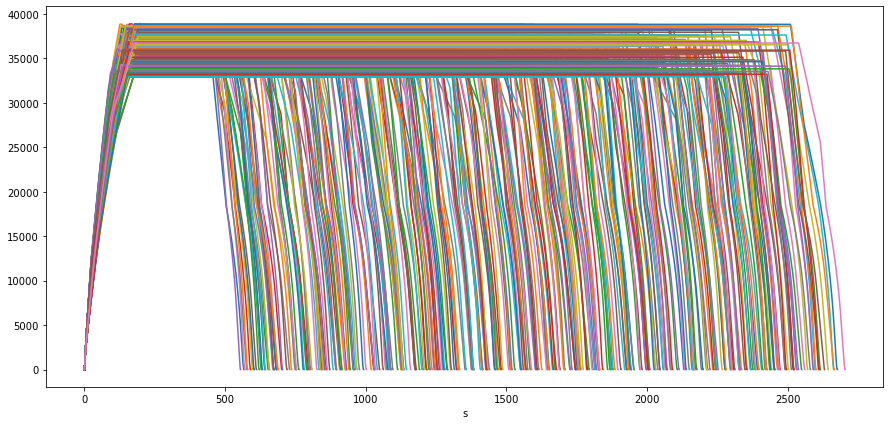

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
for (_, fp) in flight_profiles.assign(
    h=flight_profiles.h / aero.ft, s=flight_profiles.s / aero.nm
).groupby("id"):
    fp.plot(x="s", y="h", ax=ax, legend=False)

for i, range_cr in enumerate(
    range(int(wrap.cruise_range()["minimum"]), int(wrap.cruise_range()["maximum"]), 100)
):
    traj = trajs.query(f"id=={i}")
    print(
        range_cr,
        round((traj.query("fp=='CR'").s.max() - traj.query("fp=='CR'").s.min()) / 1e3),
    )

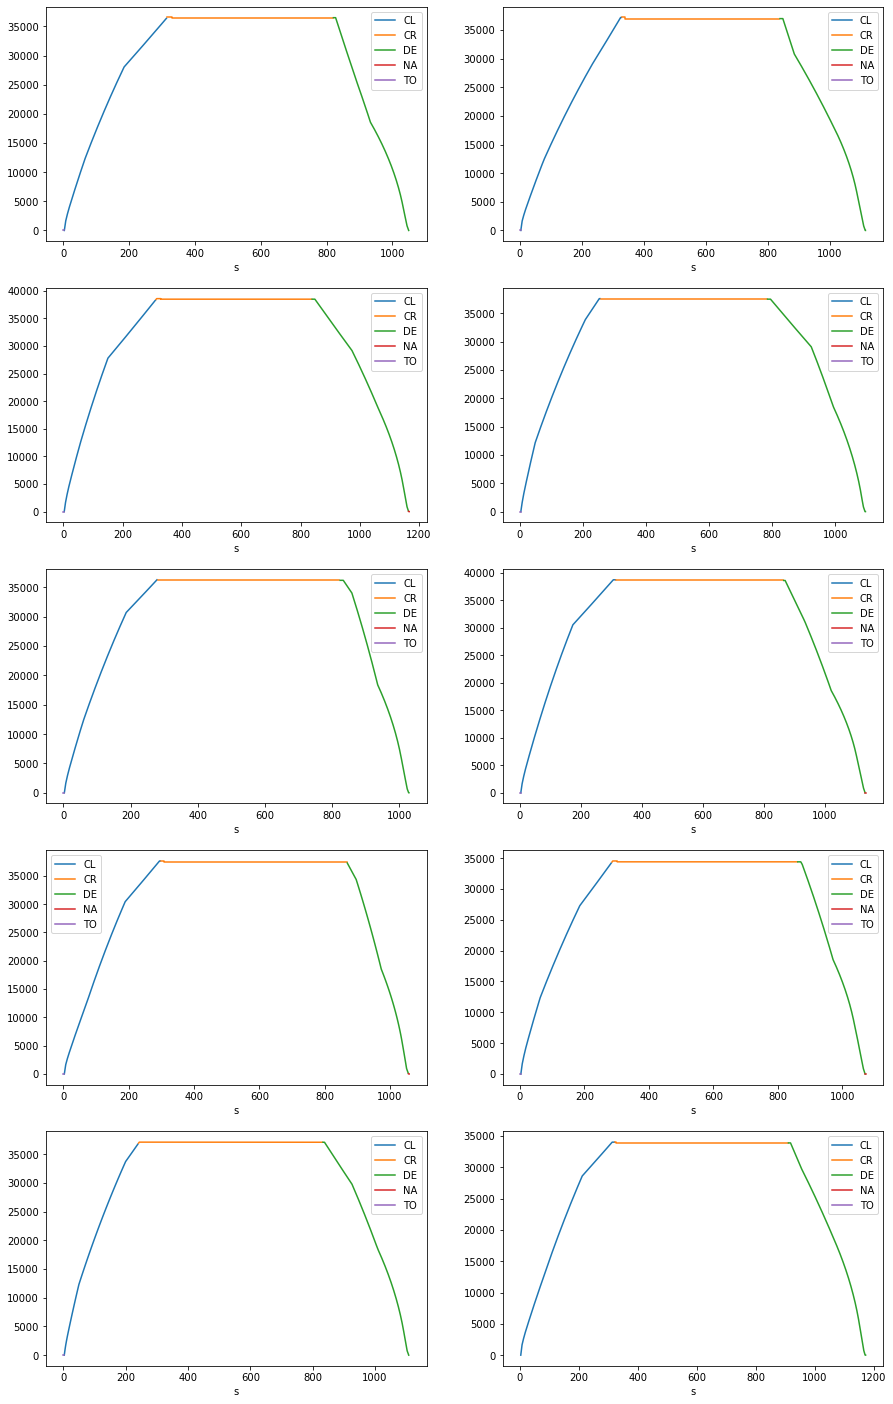

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fprof) in zip(
    axes.flat,
    flight_profiles.assign(
        h=flight_profiles.h / aero.ft, s=flight_profiles.s / 1e3
    ).groupby("id"),
):
    for fp, fprof_fp in fprof.groupby("fp"):
        fprof_fp.plot(x="s", y="h", ax=ax, label=fp)

In [8]:
prop.aircraft(ac_type)

{'aircraft': 'Airbus A320',
 'fuselage': {'length': 37.57, 'height': 4.14, 'width': 3.95},
 'wing': {'area': 124, 'span': 35.8, 'mac': 4.29, 'sweep': 25, 't/c': None},
 'flaps': {'type': 'single-slotted', 'area': 21.1, 'bf/b': 0.78},
 'limits': {'MTOW': 78000,
  'MLW': 66000,
  'OEW': 42600,
  'MFC': 24210,
  'VMO': 350,
  'MMO': 0.82,
  'ceiling': 12500},
 'cruise': {'height': 11000, 'mach': 0.78},
 'engine': {'type': 'turbofan',
  'mount': 'wing',
  'number': 2,
  'default': 'CFM56-5B4',
  'options': {'A320-111': 'CFM56-5-A1',
   'A320-211': 'CFM56-5-A1',
   'A320-212': 'CFM56-5A3',
   'A320-214': 'CFM56-5B4',
   'A320-215': 'CFM56-5B5',
   'A320-216': 'CFM56-5B6',
   'A320-231': 'V2500-A1',
   'A320-232': 'V2527-A5',
   'A320-233': 'V2527E-A5'}}}

In [9]:
thre = ThrustEstimator(ac_type=ac_type)
flight_profiles = thre(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187
...,...,...,...,...,...,...,...,...
2292,22900,0.0,5.005353e+06,59.8,0.0,386,DE,9328.929610
2293,22910,0.0,5.005951e+06,47.6,0.0,386,DE,9827.609626
2294,22920,0.0,5.006427e+06,35.4,0.0,386,NA,NaN
2295,22930,0.0,5.006781e+06,23.2,0.0,386,NA,NaN


In [10]:
me = MassEstimator(ac_type=ac_type)
fe = FuelEstimator(ac_type=ac_type, mass=me.reference_mass)
flight_profiles = fe(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr,ff
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186,2.337624
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217,2.161416
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062,2.007156
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718,1.872074
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187,1.753919
...,...,...,...,...,...,...,...,...,...
2292,22900,0.0,5.005353e+06,59.8,0.0,386,DE,9328.929610,0.095429
2293,22910,0.0,5.005951e+06,47.6,0.0,386,DE,9827.609626,0.100454
2294,22920,0.0,5.006427e+06,35.4,0.0,386,NA,NaN,NaN
2295,22930,0.0,5.006781e+06,23.2,0.0,386,NA,NaN,NaN


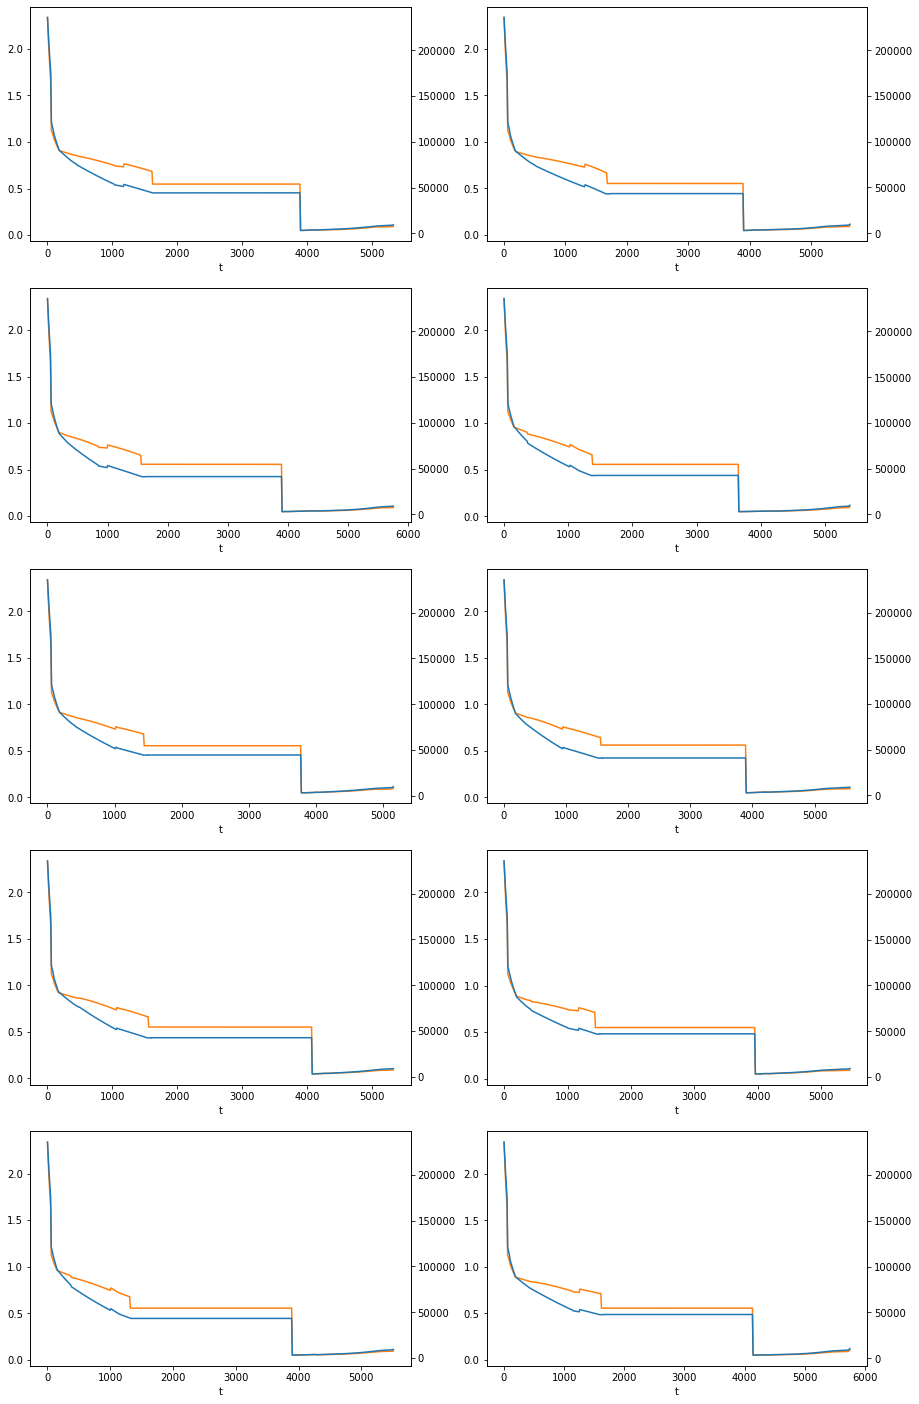

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fp) in zip(axes.flat, flight_profiles.groupby("id")):
    fp.query("ff==ff").plot(
        x="t",
        y=["thr", "ff"],
        secondary_y="thr",
        ax=ax,
        legend=False,
    )

In [12]:
flight_profiles = fe.compute_fuel_per_segment(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr,ff,fc
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186,2.337624,23.376240
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217,2.161416,44.990398
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062,2.007156,65.061956
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718,1.872074,83.782700
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187,1.753919,101.321887
...,...,...,...,...,...,...,...,...,...,...
2292,22900,0.0,5.005353e+06,59.8,0.0,386,DE,9328.929610,0.095429,12206.765196
2293,22910,0.0,5.005951e+06,47.6,0.0,386,DE,9827.609626,0.100454,12207.769740
2294,22920,0.0,5.006427e+06,35.4,0.0,386,NA,NaN,NaN,NaN
2295,22930,0.0,5.006781e+06,23.2,0.0,386,NA,NaN,NaN,NaN


In [13]:
fc = fe.compute_fuel_per_flight(flight_profiles)
fc

,id,fd,fc
0,0,1.049581e+06,2731.405978
1,1,1.114616e+06,2779.060016
2,2,1.163654e+06,2734.378974
3,3,1.094920e+06,2594.848941
4,4,1.028929e+06,2642.268370
...,...,...,...
382,382,4.844804e+06,11659.529775
383,383,4.834418e+06,11770.955801
384,384,4.795713e+06,11565.050356
385,385,4.872010e+06,11861.956395


In [14]:
min(fc.fc)

2594.8489412500603

In [15]:
fc = pd.read_pickle("fc.pkl")
fig, ax = plt.subplots(figsize=(15, 7))
fc.assign(fd=fc.fd / 1e3).plot.scatter(
    x="fd",
    y="fc",
    ax=ax,
    xlabel="Distance (km)",
    ylabel="Fuel (Kg)",
    yticks=range(2000, 13000, 500),
)

FileNotFoundError: [Errno 2] No such file or directory: 'fc.pkl'

In [ ]:
fc.to_pickle("fc.pkl")

In [ ]:
from feat import FeatModelReduction
import pandas as pd

fc = pd.read_pickle("fc.pkl")
fmr = FeatModelReduction(ac_type)
results = fmr.fit(fc.assign(fd=fc.fd / 1e3))
results.params

In [ ]:
fc.assign(fd=fc.fd / 1e3)

In [ ]:
# 0.00013004233744107196,2.4260951197123437,1310.7950948662055
import statsmodels.formula.api as sm

model = sm.ols(formula="fc ~ fd + I(fd**2)", data=fc).fit()
model.summary()

In [ ]:
pd.read_csv("ac_model_coefficients.csv").query("ac_code_icao=='A320'")[
    ["reduced_fuel_a1", "reduced_fuel_a2", "reduced_fuel_intercept"]
]

In [ ]:
import numpy as np

model = np.poly1d(np.polyfit(fc.fd.values / 1e3, fc.fc.values, 2))
model

In [ ]:
polyline = np.linspace(0, 6000, 100)
plt.scatter(fc.fd.values / 1e3, fc.fc.values)
plt.plot(polyline, model(polyline))
plt.show()